In [0]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
import pickle

import os

from collections import Counter
from scipy.sparse import hstack

from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/IRE_Major_Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv(root_path+'preprocessed.csv')

In [0]:
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,ask native americans take be,1,0,0,0,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home drink maga trump2020,3,2,1,1,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,amazon investigate chinese employees sell inte...,0,5,1,0,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama want liberals amp illegals move red state,2,0,0,0,NOT,NaN,NaN


In [0]:
data.drop(columns = ['subtask_b' , 'subtask_c'] , inplace = True)

# Splitting Data: Train and Test


In [0]:
Y = data['subtask_a']
X = data.drop(['subtask_a','id'],axis=1)
print("Shape of X: ",X.shape)
print("Shape of Y: ",Y.shape)


Shape of X:  (13240, 6)
Shape of Y:  (13240,)


In [0]:
data['subtask_a'].value_counts()

NOT    8840
OFF    4400
Name: subtask_a, dtype: int64

#### Observation: 
We see that the dataset is clearly imbalanced with NOT OFFENSIVE tweets being the majority class.


In [0]:
#separating data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30,stratify=Y,random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of Y_test: ",Y_test.shape)

Shape of X_train:  (9268, 6)
Shape of Y_train:  (9268,)
Shape of X_test:  (3972, 6)
Shape of Y_test:  (3972,)


#### Change the mapping of the label column to binary


In [0]:
Y_train = Y_train.map(dict(OFF=1, NOT=0))
Y_test = Y_test.map(dict(OFF=1, NOT=0))

# Making Data Model Ready: Encoding Tweets

## 1. Bag of Words : Tweets


In [0]:
vectorizer_tweet_bow = CountVectorizer(min_df=5,ngram_range=(1,2))
vectorizer_tweet_bow.fit(X_train['new_tweet'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=5,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
X_train_tweet_bow = vectorizer_tweet_bow.transform(X_train['new_tweet'])
X_test_tweet_bow = vectorizer_tweet_bow.transform(X_test['new_tweet'])

print("Shape of X_train_tweet_bow ",X_train_tweet_bow.shape)
print("Shape of X_test_tweet_bow ",X_test_tweet_bow.shape)

Shape of X_train_tweet_bow  (9268, 3752)
Shape of X_test_tweet_bow  (3972, 3752)


##2. TF-IDF : Tweets

In [0]:
vectorizer_tweet_tfidf = TfidfVectorizer(min_df=5,ngram_range=(1,2))
vectorizer_tweet_tfidf.fit(X_train['new_tweet'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
X_train_tweet_tfidf = vectorizer_tweet_tfidf.transform(X_train['new_tweet'])
X_test_tweet_tfidf = vectorizer_tweet_tfidf.transform(X_test['new_tweet'])

print("Shape of X_train_tweet_tfidf ",X_train_tweet_tfidf.shape)
print("Shape of X_test_tweet_tfidf ",X_test_tweet_tfidf.shape)

Shape of X_train_tweet_tfidf  (9268, 3752)
Shape of X_test_tweet_tfidf  (3972, 3752)


##3. Avg W2Vec : Tweets

In [0]:
# average Word2Vec
from scipy.sparse import csr_matrix  ## to make data type consistency across all methods


def get_avg_w2v(corpus):
    with open(root_path+'glove_vectors', 'rb') as f:
      model = pickle.load(f)
      glove_words =  set(model.keys())

    avg_w2v_vectors=[]
    for sentence in tqdm(corpus): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return csr_matrix(avg_w2v_vectors)

In [0]:
X_train_tweet_avg_w2v_vectors = get_avg_w2v(X_train['new_tweet'])
X_test_tweet_avg_w2v_vectors = get_avg_w2v(X_test['new_tweet'])

100%|██████████| 3972/3972 [00:00<00:00, 28770.93it/s]


In [0]:
# print("Shape of X_train_tweet_avg_w2v_vectors",len(X_train_tweet_avg_w2v_vectors),len(X_train_tweet_avg_w2v_vectors[0]))
# print("Shape of X_test_tweet_avg_w2v_vectors ",len(X_test_tweet_avg_w2v_vectors),len(X_test_tweet_avg_w2v_vectors[0]))
print("Shape of X_train_tweet_avg_w2v_vectors",X_train_tweet_avg_w2v_vectors.shape )
print("Shape of X_test_tweet_avg_w2v_vectors ",X_test_tweet_avg_w2v_vectors.shape )

Shape of X_train_tweet_avg_w2v_vectors (9268, 300)
Shape of X_test_tweet_avg_w2v_vectors  (3972, 300)


# Applying Naive Bayes on different featurization of Tweets

## 1. BOW



In [0]:
f1 = X_train_tweet_bow
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)

X_train_bow_naive =hstack((f1,f2,f3,f4,f5))
X_train_bow_naive.shape

(9268, 3756)

In [0]:
f1 = X_test_tweet_bow
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)

# print(type(f1))
X_test_bow_naive =hstack((f1,f2,f3,f4,f5))
X_test_bow_naive.shape

(3972, 3756)

## Hyper Parameter Tuning: Lambda (MultinomialNB)

In [0]:
tune_parameters = [{'alpha': [10**-2, 10**-1, 10**0 ]}]

#Using GridSearchCV
model = GridSearchCV(MultinomialNB(), tune_parameters,scoring = 'roc_auc', cv=10, return_train_score=True,n_jobs=-1, verbose=True)
model.fit(X_train_bow_naive, Y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.9s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=-1, param_grid=[{'alpha': [0.01, 0.1, 1]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=True)

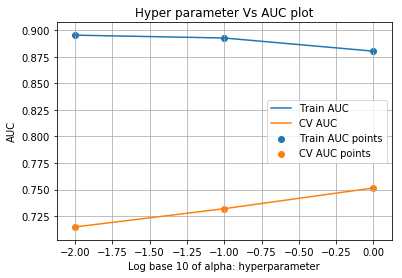

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.007642,0.001029,0.004208,0.002231,0.01,{'alpha': 0.01},0.690446,0.696224,0.719746,0.704430,0.731026,0.699429,0.718563,0.730871,0.726976,0.730719,0.714840,0.014979,3,0.895975,0.894907,0.897567,0.896470,0.892357,0.896758,0.895806,0.894824,0.894294,0.894761,0.895372,0.001401
1,0.008966,0.002588,0.004249,0.002070,0.1,{'alpha': 0.1},0.709062,0.715177,0.730750,0.724231,0.744626,0.718065,0.738358,0.743632,0.747807,0.748855,0.732053,0.013908,2,0.893057,0.892360,0.894949,0.893800,0.889783,0.893948,0.893091,0.892338,0.891575,0.892026,0.892693,0.001363
2,0.007778,0.002510,0.004311,0.001963,1,{'alpha': 1},0.733677,0.743976,0.748943,0.746601,0.765413,0.725770,0.758877,0.752387,0.769488,0.770290,0.751538,0.014114,1,0.879800,0.880725,0.882807,0.881525,0.877227,0.881473,0.880286,0.881023,0.878742,0.879535,0.880314,0.001502


In [0]:
results = pd.DataFrame.from_dict(model.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
param_alpha =  results['param_alpha']

log_alpha = [(np.log(x)/np.log(10)) for x in param_alpha]

plt.plot(log_alpha, train_auc, label='Train AUC')

plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log base 10 of alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

In [0]:
model.best_estimator_

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

**Obervations:**

1. We can see both from the graph as well as from the API response that the best value of C = 1

2. This can be seen as value of 1 on the x-axis of the error vs logC plot.

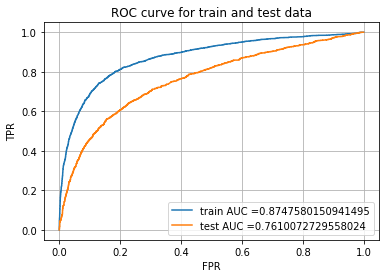

In [0]:
naive_bow = model.best_estimator_
naive_bow.fit(X_train_bow_naive,Y_train)

y_train_pred = naive_bow.predict_proba(X_train_bow_naive)
y_test_pred = naive_bow.predict_proba(X_test_bow_naive)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train.values, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test.values, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

## Results - Confusion Matrix

F1 Score = 0.7055928317631244


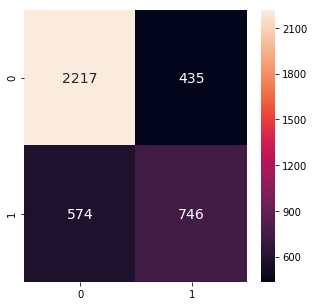

In [0]:
naive_bow = model.best_estimator_
naive_bow.fit(X_train_bow_naive,Y_train)


y_test_predict = naive_bow.predict(X_test_bow_naive)

results = confusion_matrix(Y_test, y_test_predict)
plt.figure(figsize = (5,5))
sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')

print("F1 Score = " + str(f1_score(Y_test,y_test_predict,average= 'macro')))

In [0]:
from sklearn.metrics import classification_report
target_names = ['0', '1'] #0- not, 1- off
print(classification_report(Y_test, y_test_predict, target_names=target_names))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      2652
           1       0.63      0.57      0.60      1320

    accuracy                           0.75      3972
   macro avg       0.71      0.70      0.71      3972
weighted avg       0.74      0.75      0.74      3972



### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

1009 misclassifications


In [0]:
def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk)) 

Red: original not offensive (0), classified as offensive (1) <br>
Green: original offensive (1), classified as not offensive (0)

In [0]:
#OFF=1, NOT=0)
for index in misclassified[0]:
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prGreen(X_test.iloc[index,0])

 @USER @USER Conservatives have killed hundreds 100000 people as a direct result of conservative policies DWP figures she is such an imbecile Tony Blair put 6% into the NHS Gordon Brown 5.5% that's not fit to be an MP 1.5% she's stealing the National Health Service of us. Chemical attacks
 @USER @USER You ain’t doin your part then 😂 check them pussies. I’m from the hood and I still don’t say the N word cause I’m a little more educated I got other ways to describe my brother or friends. I feel the same way as you though too many people going left unchecked.
 @USER I thought it was because you weren't very funny and lacked in talent as a comedian.
 . @USER ALL I HAVE TO SAY IS I #TasteTheBARBIERAINBOW &amp;  facial expressions were everything I see you 👀 #ROMAN THIS VIDEO WAS #LEGENDARY YOU ARE A FUCKING #ICON #BarbieDreamsVIDEO URL
 @USER Crazy Maxine is either huffing spray paint or smoking crack. #MAGA
 @USER I mean if he is willing to move up for Canelo. Then i want to see him vs a C

## 2. TF-IDF


In [0]:
f1 = X_train_tweet_tfidf
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)

# print(type(f1))
X_train_tfidf =hstack((f1,f2,f3,f4,f5))
X_train_tfidf.shape

(9268, 3756)

In [0]:
f1 = X_test_tweet_tfidf
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)

X_test_tfidf =hstack((f1,f2,f3,f4,f5))
X_test_tfidf.shape

(3972, 3756)

## Hyper Parameter Tuning: Lambda (MultinomialNB)

In [0]:
tune_parameters = [{'alpha': [10**-2, 10**-1, 10**0 ]}]
#Using GridSearchCV
model = GridSearchCV(MultinomialNB(), tune_parameters,scoring = 'roc_auc', cv=10, return_train_score=True,n_jobs=-1, verbose=True)
model.fit(X_train_bow_naive, Y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.3s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=-1, param_grid=[{'alpha': [0.01, 0.1, 1]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=True)

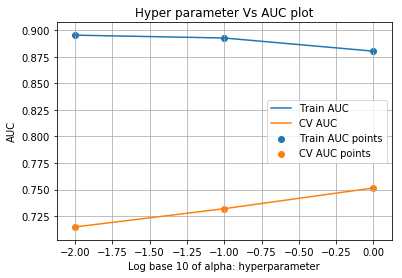

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.009941,0.003336,0.003420,0.000310,0.01,{'alpha': 0.01},0.690446,0.696224,0.719746,0.704430,0.731026,0.699429,0.718563,0.730871,0.726976,0.730719,0.714840,0.014979,3,0.895975,0.894907,0.897567,0.896470,0.892357,0.896758,0.895806,0.894824,0.894294,0.894761,0.895372,0.001401
1,0.008534,0.001990,0.003900,0.000576,0.1,{'alpha': 0.1},0.709062,0.715177,0.730750,0.724231,0.744626,0.718065,0.738358,0.743632,0.747807,0.748855,0.732053,0.013908,2,0.893057,0.892360,0.894949,0.893800,0.889783,0.893948,0.893091,0.892338,0.891575,0.892026,0.892693,0.001363
2,0.007754,0.002118,0.003209,0.000511,1,{'alpha': 1},0.733677,0.743976,0.748943,0.746601,0.765413,0.725770,0.758877,0.752387,0.769488,0.770290,0.751538,0.014114,1,0.879800,0.880725,0.882807,0.881525,0.877227,0.881473,0.880286,0.881023,0.878742,0.879535,0.880314,0.001502


In [0]:
results = pd.DataFrame.from_dict(model.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
param_alpha =  results['param_alpha']

log_alpha = [(np.log(x)/np.log(10)) for x in param_alpha]

plt.plot(log_alpha, train_auc, label='Train AUC')

plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log base 10 of alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

In [0]:
model.best_estimator_

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

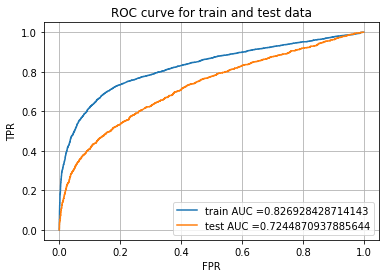

In [0]:
naive_tfidf = model.best_estimator_
naive_tfidf.fit(X_train_bow_naive,Y_train)

y_train_pred = naive_tfidf.predict_proba(X_train_tfidf)
y_test_pred = naive_tfidf.predict_proba(X_test_tfidf)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train.values, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test.values, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

## Result - Confusion Matrix

F1 Score = 0.6581487694932056


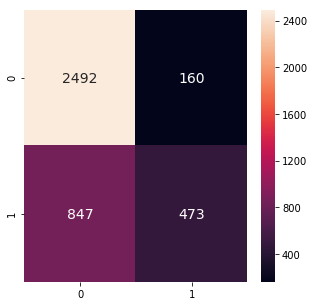

In [0]:
naive_tfidf = model.best_estimator_
naive_tfidf.fit(X_train_tfidf,Y_train)

y_test_predict = naive_tfidf.predict(X_test_tfidf)

results = confusion_matrix(Y_test, y_test_predict)
plt.figure(figsize = (5,5))
sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')

print("F1 Score = " + str(f1_score(Y_test,y_test_predict,average= 'macro')))

### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

1093 misclassifications


Red: original not offensive (0), classified as offensive (1) <br>
Green: original offensive (1), classified as not offensive (0)

In [0]:
#OFF=1, NOT=0)
for index in misclassified[0]:
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prGreen(X_test.iloc[index,0])

 .@USER is staffed with unhinged Liberals &amp; @USER  This is a disgusting statement. URL
 @USER This is all political theater. Are liberals really that stupid to believe that the FBI investigates state crimes? Especially incidents that happened 36 years ago by a juvenile? This is nothing more than a tactic to delay Kavanaugh’s confirmation.
 @USER The same is with Union Teachers. That is why Our Children Learn Zero and are Brain Washed by Liberals. Vote to STOP IT NOW.
 @USER What about the other to girls was that sinnfeinn fault as well oh right it's only the ex hard line republic you are interested in she is the only victim because she would do aunt thing to bad mouth sinnfeinn shame on you
 @USER Hi has me energized.  @USER  He is such an idiot!  I can’t believe he “surfaced” again.
 @USER All that money hadn't made u smarter.
 @USER @USER @USER We are calling you an operative . Or Shill. And more important a bigot for refusing to apologize for your actions to a woman just because

# 3. AvgW2Vec 

In [0]:
f1 = X_train_tweet_avg_w2v_vectors

f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)

X_train_w2vec =hstack((f1,f2,f3,f4,f5))
X_train_w2vec.shape


min_value_train = X_train_w2vec.min()
max_value_train = X_train_w2vec.max()

In [0]:

f1 = X_test_tweet_avg_w2v_vectors
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)

X_test_w2vec =hstack((f1,f2,f3,f4,f5))
X_test_w2vec.shape

min_value_test = X_test_w2vec.todense().min()
max_value_test = X_test_w2vec.todense().max()

## Hyper parameter tuning

In [0]:
tune_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(class_weight='balanced'), tune_parameters, scoring = 'roc_auc', cv=10, return_train_score=True,n_jobs=-1, verbose=True)
model.fit(X_train_w2vec, Y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   51.8s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=True)

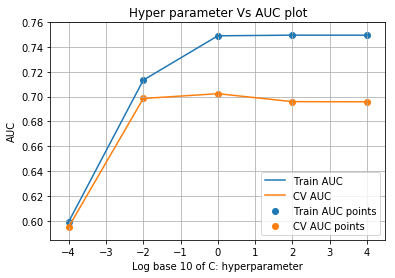

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.319137,0.019680,0.004181,0.000788,0.0001,{'C': 0.0001},0.571214,0.596996,0.622758,0.611683,0.599849,0.586870,0.592881,0.611483,0.588978,0.568723,0.595147,0.016464,5,0.604045,0.599982,0.593275,0.600772,0.594634,0.601587,0.599572,0.598031,0.599813,0.601254,0.599297,0.003069
1,0.690939,0.016423,0.003709,0.000357,0.01,{'C': 0.01},0.702662,0.665881,0.755041,0.707396,0.697850,0.682500,0.704388,0.684554,0.699825,0.684324,0.698443,0.022464,2,0.712654,0.717066,0.707839,0.712178,0.711802,0.715518,0.712681,0.714334,0.713909,0.713711,0.713169,0.002338
2,2.123788,0.130483,0.003692,0.000149,1,{'C': 1},0.710897,0.682151,0.753735,0.703719,0.702655,0.685217,0.704288,0.686924,0.709177,0.684245,0.702302,0.020083,1,0.745994,0.751399,0.743528,0.747887,0.749260,0.750631,0.750180,0.750110,0.749030,0.750343,0.748836,0.002299
3,3.274316,0.344722,0.003654,0.000099,100,{'C': 100},0.705421,0.678354,0.744529,0.698805,0.695012,0.682170,0.695471,0.681123,0.702646,0.675424,0.695897,0.019091,3,0.746710,0.752109,0.743776,0.748368,0.749885,0.751136,0.750801,0.750554,0.749365,0.750838,0.749354,0.002363
4,3.457306,0.246770,0.003580,0.000329,10000,{'C': 10000},0.705311,0.678238,0.744325,0.698673,0.694771,0.682091,0.695214,0.680976,0.702588,0.675325,0.695753,0.019069,4,0.746699,0.752087,0.743770,0.748348,0.749860,0.751117,0.750755,0.750522,0.749295,0.750807,0.749326,0.002356


In [0]:
results = pd.DataFrame.from_dict(model.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
param_C =  results['param_C']

log_C = [(np.log(x)/np.log(10)) for x in param_C]

plt.plot(log_C, train_auc, label='Train AUC')

plt.plot(log_C, cv_auc, label='CV AUC')

plt.scatter(log_C, train_auc, label='Train AUC points')
plt.scatter(log_C, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Log base 10 of C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

In [0]:
model.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

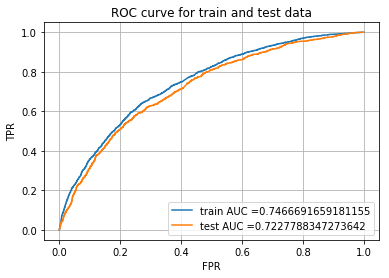

In [0]:
lr_w2vec = model.best_estimator_
lr_w2vec.fit(X_train_w2vec,Y_train)

y_train_pred = lr_w2vec.predict_proba(X_train_w2vec)
y_test_pred = lr_w2vec.predict_proba(X_test_w2vec)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

## Result - Confusion Matrix 

F1 Score = 0.5916946367171972


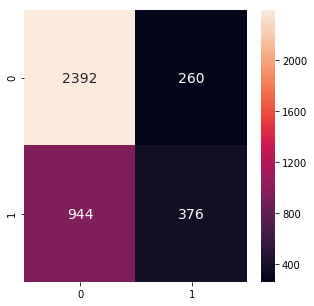

In [0]:
naive_w2vec = MultinomialNB(fit_prior=False)

scaler = MinMaxScaler()
scaler.fit(X_train_w2vec.todense())
X_train_w2vec2 = scaler.transform(X_train_w2vec.todense())

naive_w2vec.fit(X_train_w2vec2,Y_train)

scaler = MinMaxScaler()
scaler.fit(X_test_w2vec.todense())

X_test_w2vec2 = scaler.transform(X_test_w2vec.todense())
y_test_predict = naive_w2vec.predict(X_test_w2vec2)


results = confusion_matrix(Y_test, y_test_predict)
plt.figure(figsize = (5,5))
sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')

print("F1 Score = " + str(f1_score(Y_test,y_test_predict,average= 'macro')))


### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

1204 misclassifications


Red: original not offensive (0), classified as offensive (1) <br>
Green: original offensive (1), classified as not offensive (0)

In [0]:
#OFF=1, NOT=0)
for index in misclassified[0]:
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prGreen(X_test.iloc[index,0])

 @USER @USER As well this would allow you to still protest. But not stop a speaker or a group. Really Hitler did this in the early time of the Nazi party a group known as the SS would beat up politicians and people that didn't agree with them. (Sounds familiar smells like Antifa.)
 @USER @USER Conservatives have killed hundreds 100000 people as a direct result of conservative policies DWP figures she is such an imbecile Tony Blair put 6% into the NHS Gordon Brown 5.5% that's not fit to be an MP 1.5% she's stealing the National Health Service of us. Chemical attacks
 @USER The antifa of the Muslim world
 @USER And, he proved that all the gun Control" LAWS doesn't stop anyone willing to break the LAW. He could have just as easily shot a colleague or student.  Or, several.  LAX enforcement of existing LAWS and Criminal Minds ignoring laws are the REAL problem.  But, DemocRats know that."
 @USER @USER You ain’t doin your part then 😂 check them pussies. I’m from the hood and I still don’t s